# This notebook allows us to see what output SynthMorph gives us if we give it a pair of 2D label maps containing a single line of data as input

## 1. Import of all the libraries and packages needed to run the code

In [6]:
import numpy as np
import odl
import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm

## 2. Recovering SynthMorph trained with 2D label maps

In [7]:
# Input shapes.
in_shape = (256,) * 2 # Label maps dimensions.
num_dim = len(in_shape)
num_label = 16
num_maps = 40 # The number of data pairs we want to train the model with.

# Shape generation.
label_maps = []
for _ in tqdm.tqdm(range(num_maps)):
    # Draw image and warp.
    im = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label),
        scales=(32, 64), max_std=1,
    )
    warp = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label, num_dim),
        scales=(16, 32, 64), max_std=16,
    )

    # Transform and create label map.
    im = vxm.utils.transform(im, warp)
    lab = tf.argmax(im, axis=-1)
    label_maps.append(np.uint8(lab))
    # The label_maps list contains all the data pairs generated above.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.83it/s]


In [8]:
# Image generation. For accurate registration, the landscape of generated warps
# and image contrasts will need to include the target distribution.
gen_arg = dict(
    in_shape=in_shape,
    in_label_list=np.unique(label_maps),
    warp_std=3,
    warp_res=(8, 16, 32),
)
# We separate the grey-scale images created from the label_maps list into two different lists: 
# one containing the grey-scale images corresponding to the "fixed" images and 
# another containing those corresponding to the "moving" images.
gen_model_1 = ne.models.labels_to_image(**gen_arg, id=1)
gen_model_2 = ne.models.labels_to_image(**gen_arg, id=2)

In [9]:
# Registration model.
reg_model = vxm.networks.VxmDense(
    inshape=in_shape,
    int_resolution=2,
    svf_resolution=2,
    nb_unet_features=([256] * 4, [256] * 8),
    reg_field='warp',
)


# Model for optimization.
ima_1, map_1 = gen_model_1.outputs
ima_2, map_2 = gen_model_2.outputs

_, warp = reg_model((ima_1, ima_2))
pred = vxm.layers.SpatialTransformer(fill_value=0)((map_1, warp))

inputs = gen_model_1.inputs + gen_model_2.inputs
out = (map_2, pred)
model = tf.keras.Model(inputs, out)


# Compilation.
model.add_loss(vxm.losses.Dice().loss(*out) + tf.repeat(1., tf.shape(pred)[0]))
model.add_loss(vxm.losses.Grad('l2', loss_mult=1).loss(None, warp))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

In [ ]:
# Train model for a few epochs. 
# Re-running the cell will continue training.
gen = vxm.generators.synthmorph(
    label_maps,
    batch_size=1,
    same_subj=True,
    flip=True,
)

hist = model.fit(
    gen,
    initial_epoch=0,
    epochs=1,
    steps_per_epoch=100,
    verbose=1, # Visualise the progress bar.
)

2023-08-22 17:06:20.536890: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.
2023-08-22 17:06:20.579144: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.
2023-08-22 17:06:20.982215: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 150994944 exceeds 10% of free system memory.
2023-08-22 17:06:20.982263: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 150994944 exceeds 10% of free system memory.
2023-08-22 17:06:21.042396: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 150994944 exceeds 10% of free system memory.


 89/100 [=========================>....] - ETA: 20s - loss: 0.3372

In [25]:
# Download model weights to skip training and save time.
model.load_weights('weights_of_the_U-Net_trained_with_2D_label_maps.h5')

In [18]:
# Conform test data.
def conform(x, in_shape=(256,256)):
    '''Resize and normalize image.'''
    x = np.float32(x)
    x = np.squeeze(x)
    x = ne.utils.minmax_norm(x)
    x = ne.utils.zoom(x, zoom_factor=[o / i for o, i in zip(in_shape, x.shape)])
    return np.expand_dims(x, axis=(0, -1))

## 3. Creation of one image and its warped version

In [19]:
# Input shapes.
in_shape = (1, 256) # Label maps dimensions.
num_dim = len(in_shape)
num_label = 16
num_maps = 1

# Shape generation.
label_maps = []
for _ in tqdm.tqdm(range(num_maps)):
    # Draw image and warp.
    im = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label),
        scales=(32, 64), max_std=1,
    )
    warp = ne.utils.augment.draw_perlin(
        out_shape=(*in_shape, num_label, num_dim),
        scales=(16, 32, 64), max_std=16,
    )

    # Transform and create label map.
    warped_im = vxm.utils.transform(im, warp)
    lab = tf.argmax(im, axis=-1)
    # Creation of an image full of 0 with dimensions multiples of 16.
    lab_bis = np.zeros((256, 256), dtype=np.uint8)
    # Insertion of the line of data in the middle of the image.
    lab_bis[128,:] = lab    
    label_maps.append(np.uint8(lab_bis))
    warped_lab = tf.argmax(warped_im, axis=-1)
    # Creation of an image full of 0 with dimensions multiples of 16.
    warped_lab_bis = np.zeros((256, 256), dtype=np.uint8)
    # Insertion of the line of data in the middle of the image.
    warped_lab_bis[128,:] = warped_lab
    label_maps.append(np.uint8(warped_lab_bis))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


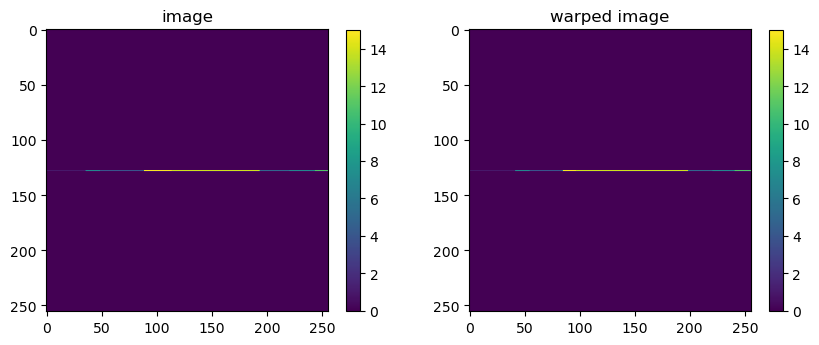

In [20]:
#Visualise one image and its warped version
fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(lab_bis[:,:])
plt.title("image")
plt.colorbar(shrink = 0.52)

fig.add_subplot(rows, columns, 2)
plt.imshow(warped_lab_bis[:,:])
plt.title("warped image")
plt.colorbar(shrink = 0.52)

## 4. The output of the model if we put two 2D label maps with a single line of data as inputs

1/1 [==============================] - 2s 2s/step


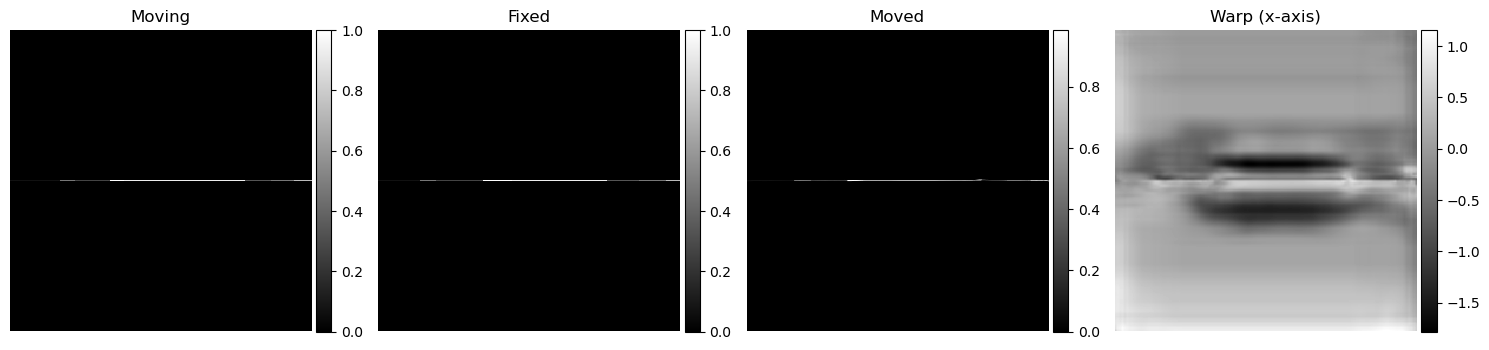

In [21]:
# Test the model with those images
moving = conform(warped_lab_bis[:,:])
fixed = conform(lab_bis[:,:])
moved, warp = reg_model.predict((moving, fixed))


ne.plot.slices(
    slices_in=(moving, fixed, moved, warp[..., 0]),
    titles=('Moving', 'Fixed', 'Moved', 'Warp (x-axis)'),
    do_colorbars=True,
);

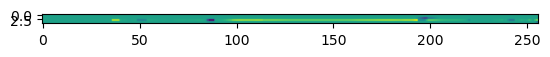

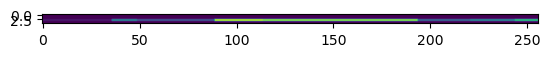

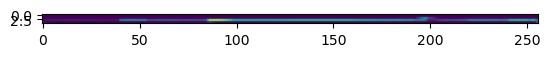

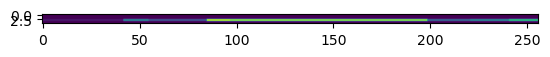

In [22]:
plt.figure()
plt.imshow((fixed - moved)[0,125:130,:,0])
plt.figure()
plt.imshow(fixed[0,125:130,:,0])
plt.figure()
plt.imshow(moved[0,125:130,:,0]);
plt.figure()
plt.imshow(moving[0,125:130,:,0]);


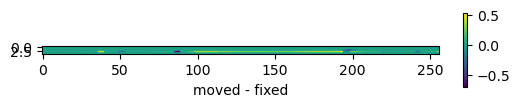

In [24]:
# Visualise the difference between the "moved" and the "fixed" image.
plt.imshow((fixed-vxm.layers.SpatialTransformer(fill_value=0)((moving, warp)))[0,125:130,:,0])
plt.xlabel('moved - fixed');
plt.colorbar(shrink=0.2)

In [1]:
# Here is the difference between the fixed and the deformation applied to the moving, 
# if the prediction of the network where good this difference should be null but here is not the case !